# TFM - Detección de melanoma mediante redes neuronales

Basado en competición:
https://www.kaggle.com/c/siim-isic-melanoma-classification


# Inicialización del entorno

### Instalar EfficientNet

In [1]:
! /opt/conda/bin/python3.7 -m pip install -q --upgrade pip
! pip install -q efficientnet

### Importar librerias

In [2]:
import os, random, re, math, time
random.seed(a=42)

from glob import glob
import pandas as pd, numpy as np, matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
print("Tensorflow version " + tf.__version__)

from kaggle_datasets import KaggleDatasets
import PIL


Tensorflow version 2.3.0


### Configuración de TPU

In [3]:
# Configuración de acelerador
DEVICE = "TPU" # o GPU

if DEVICE == "TPU":
    print("Conectando A TPU...")
    # Detectar el hardware, devolver la distribution strategy apropiada
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Ejecución en TPU ', tpu.master())
    except ValueError:
        print("No se pudo conectar a TPU")
        tpu = None

    if tpu:
        try:
            print("Inicializando TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU inicializada")
        except _:
            print("Error en inicialización de TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Usando strategy por defecto para CPU y GPU simple")
    strategy = tf.distribute.get_strategy() # Distribution strategy por defecto en Tensorflow

if DEVICE == "GPU":
    print("Num GPUs Disponibles: ", len(tf.config.experimental.list_physical_devices('GPU')))

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print("REPLICAS: ", strategy.num_replicas_in_sync)


Conectando A TPU...
No se pudo conectar a TPU
Usando strategy por defecto para CPU y GPU simple
Num GPUs Disponibles:  0
REPLICAS:  1


### Configuración

In [6]:
# Creamos diccionario de configuraciones del proceso
CFG = dict(
    # Raiz de ejecución
    SEED = 42,
    # Flag para mostrar plot de entrenamiento
    DISPLAY_PLOT = True,
    
    # Configuración entrenamiento
    VERBOSE = 2,
    IMG_SIZE = 384,
    BATCH_SIZE = 16 * REPLICAS,
    EPOCHS = 6,
    EFF_NET = 1,
    LABEL_SMOOTH = 0.05,
    
    # Si FOLDS=1, calcula con una única partición fija
    FOLDS = 1,
    
    # Fuentes de datos
    INC2019 = 0,
    INC2018 = 0,
    
    # Upsample de imagenes de melanoma
    M1 = 0,
    M2 = 0,
    M3 = 0,
    M4 = 0,
    
    # Aumento de imagen basica con tf.image
    # tf.image.random_brightness
    DELTA_BR = 0.1,
    # tf.image.random_contrast
    LOWER_CT = 0.8,
    UPPER_CT = 1.2,
    # tf.image.random_hue
    MAX_DELTA_H = 0.1,
    # tf.image.random_saturation
    LOWER_SAT = 0.7,
    UPPER_SAT = 1.3,
        
    # Aumento de imagen
    # Rotacion
    ROT = 180.0,
    # Shear
    SHR = 2.0,
    # Zoom
    HZOOM = 8.0,
    WZOOM = 8.0,
    # Desplazamiento
    HSHIFT = 8.0,
    WSHIFT = 8.0,
    
    # Coarse Dropout
    # Frecuencia ocurrencia
    DROP_FREQ = 0.65, 
    # Número de cuadrados eliminados
    DROP_CT = 4,
    # Tamaño de cuadrados eliminados (factor 0-1)
    DROP_SIZE = 0.1,
    
    # Número de imágenes a aplicar TTA
    TTA = 20,
        
    # Learning Rate Schedule, distintos perfiles
    # LR 1
    LR_START = 0.00003,
    LR_MAX = 0.0000125,
    LR_MIN = 0.00001,
    LR_RAMPUP_EPOCHS  = 3,
    LR_SUSTAIN_EPOCHS = 0,
    LR_EXP_DECAY = 0.8
    
    # LR 2 
#   LR_START = 0.00001,
#   LR_MAX = 0.0000075,
#   LR_MIN = 0.00001,
#   LR_RAMPUP_EPOCHS  = 3,
#   LR_SUSTAIN_EPOCHS = 0,
#   LR_EXP_DECAY = 0.8
    
     # LR3
#    LR_START = 0.00003,
#    LR_MAX = 0.0000125,
#    LR_MIN = 0.00001,
#    LR_RAMPUP_EPOCHS  = 6,
#    LR_SUSTAIN_EPOCHS = 0,
#    LR_EXP_DECAY = 0.8
    
     # LR 4
#    LR_START = 0.000005,
#    LR_MAX = 0.00000125 * 16 * REPLICAS,
#    LR_MIN = 0.000001,
#    LR_RAMPUP_EPOCHS  = 4,
#    LR_SUSTAIN_EPOCHS = 0,
#    LR_EXP_DECAY = 0.8

)

In [29]:
# Definimos en función de CFG el nombre genérico para el modelo de trabajo
MODEL_NAME = 'EFFN{}_{}_B{}E{}'.format(CFG['EFF_NET'], CFG['IMG_SIZE'], CFG['BATCH_SIZE'], CFG['EPOCHS'])

# Incorporamos info de tipo flag
if CFG['FOLDS']>1: MODEL_NAME = MODEL_NAME+'_CV'+CFG['FOLDS']

if CFG['INC2019'] and not CFG['INC2018']: MODEL_NAME = MODEL_NAME+'_EXT19'
if CFG['INC2018'] and not CFG['INC2019']: MODEL_NAME = MODEL_NAME+'_EXT18'
if CFG['INC2018'] and CFG['INC2018']: MODEL_NAME = MODEL_NAME+'_EXT1918'

if CFG['M1']: MODEL_NAME = MODEL_NAME+'_M1'
if CFG['M2']: MODEL_NAME = MODEL_NAME+'_M2'
if CFG['M3']: MODEL_NAME = MODEL_NAME+'_M3'
if CFG['M4']: MODEL_NAME = MODEL_NAME+'_M4'

print('El nombre del modelo en curso: ' + MODEL_NAME)

El nombre del modelo en curso: EFFN1_384_B128E6


### Lectura de datos

In [30]:
# Leemos CSV 
BASEPATH = "../input/siim-isic-melanoma-classification"
df_train = pd.read_csv(os.path.join(BASEPATH, 'train.csv'))
df_test  = pd.read_csv(os.path.join(BASEPATH, 'test.csv'))
df_sub   = pd.read_csv(os.path.join(BASEPATH, 'sample_submission.csv'))

# Leemos GCS Patchs para TFRecords
# 2020 Challenge
GCS_PATH = KaggleDatasets().get_gcs_path('melanoma-%ix%i'%(CFG['IMG_SIZE'],CFG['IMG_SIZE']))
GCS_PATH_PREV = KaggleDatasets().get_gcs_path('isic2019-%ix%i'%(CFG['IMG_SIZE'],CFG['IMG_SIZE']))
GCS_PATH_MALIG = KaggleDatasets().get_gcs_path('malignant-v2-%ix%i'%(CFG['IMG_SIZE'],CFG['IMG_SIZE']))

# Extraemos listado de ficheros de train
files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')))
print('Total de %i ficheros de train'%len(files_train))
# Extraemos listado de ficheros de test
files_test = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))
print('Total de %i ficheros de test'%len(files_test))

Total de 15 ficheros de train
Total de 16 ficheros de test


2022-12-15 23:33:22.020157: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-15 23:33:22.064940: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


## Carga de datos

### Funciones auxiliares para Aumento de Datos

In [31]:
# AUMENTO POR CROPPING ALEATORIO DE IMAGEN

# Establecemos el tamaño de los recortes aleatorios para cada tamaño de imagen
CROP_DICT = {128: 128, 256: 256, 384: 384, 512: 384, 768: 512, 1024: 512}
CROP_SIZE = CROP_DICT[CFG['IMG_SIZE']]

print('Imagen original imagen: %i'%CFG['IMG_SIZE'])
print('Tamaño usado para entrenar la red CNN: %i' %CROP_SIZE)

Imagen original imagen: 384
Tamaño usado para entrenar la red CNN: 384


In [38]:
# AUMENTO POR COARSE DROPOUT DE IMAGEN

def dropout(image, cfg):
    # Input - Imagen y diccionario de configuracion
    # Output - Imagen con #DROP_CT cuadrados de tamaño DROP_SIZE x CROP_SIZE; con probabilidad DROP_FREQ
    
    # Definimos dimensión y probabilidad
    DIM = CROP_SIZE
    P = tf.cast(tf.random.uniform([],0,1)<cfg['DROP_FREQ'], tf.int32)
    
    # Caso que no aplicamos dropout
    if (P==0)|(cfg['DROP_CT']==0)|(cfg['DROP_SIZE']==0): return image

    # Caso que si aplicamos dropout
    CT = cfg['DROP_CT'] 
    SZ = cfg['DROP_SIZE'] 

    for k in range(CT):
        # Coordenadas aleatorias
        x = tf.cast(tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast(tf.random.uniform([],0,DIM),tf.int32)
        
        # Calculamos región a eliminar
        WIDTH = tf.cast(SZ*DIM,tf.int32) * P
        xa = tf.math.maximum(0, x-WIDTH//2)
        xb = tf.math.minimum(DIM, x+WIDTH//2)
        ya = tf.math.maximum(0, y-WIDTH//2)
        yb = tf.math.minimum(DIM, y+WIDTH//2)

        # Aplicamos dropout a la imagen 
        izq = image[ya:yb,0:xa,:]
        drop = tf.zeros([yb-ya,xb-xa,3]) 
        der = image[ya:yb,xb:DIM,:]
        middle_drop = tf.concat([izq,drop,der],axis=1)
        image = tf.concat([image[0:ya,:,:],middle_drop,image[yb:DIM,:,:]],axis=0)
    
    image = tf.reshape(image,[DIM,DIM,3])
    return image

In [9]:
# AUMENTO POR ROTACION/SHEAR/DESPLAZAMIENTO/ZOOM DE IMAGEN

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # Input - Variables de configuración de transformaciones
    # Output - Devuelve matriz de 3x3 con indices para transformación
        
    # Conversión a rad
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # Matriz de rotación
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # Matriz de shear
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # Matriz de zoom
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # Matriz de desplazamiento
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, cfg=None):    
    # Input - Imagen a tratar y variable de configuración
    # Output - Imagen con transformación aleatoria de rotación, shear, desplazamiento y zoom
    
    DIM = cfg['IMG_SIZE']
    XDIM = DIM%2
    
    rot = cfg['ROT'] * tf.random.normal([1], dtype='float32')
    shr = cfg['SHR'] * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / cfg['HZOOM']
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / cfg['WZOOM']
    h_shift = cfg['HSHIFT'] * tf.random.normal([1], dtype='float32') 
    w_shift = cfg['WSHIFT'] * tf.random.normal([1], dtype='float32') 

    # Recuperamos matriz de transformación
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # Creamos lista de píxeles destino
    x = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # Rotamos los píxeles destino a origen
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # Recuperamos los valores origen de píxeles           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

In [10]:
# FUNCION PARA DECODIFICAR IMAGEN Y APLICAR TECNICAS DE AUMENTO

def decode_image(img, cfg=None, augment=False):
    # Input - Imagen, diccionario de configuracion y flag para aplicar data augmentation
    # Output - Imagen con transformaciones de acuerdo a la configuración
    
    # Se decodifica y normaliza imagen
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0

    # Tratamiento para aumento de imagenes
    if augment:
        # Augmento por rotación, shear, zoom y shift
        img = transform(img, cfg)
        # Aumento por cropping aleatorio
        img = tf.image.random_crop(img, [CROP_SIZE, CROP_SIZE, 3]) 
        # Augmento por dropout
        if (cfg['DROP_FREQ']!=0)&(cfg['DROP_CT']!=0)&(cfg['DROP_SIZE']!=0): 
            img = dropout(img, cfg)
        # Aumento de imagen con libreria tf.image.*
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_hue(img, cfg['MAX_DELTA_H'])
        img = tf.image.random_saturation(img, cfg['LOWER_SAT'], cfg['UPPER_SAT'])
        img = tf.image.random_contrast(img, cfg['LOWER_CT'], cfg['UPPER_CT'])
        img = tf.image.random_brightness(img, cfg['DELTA_BR'])
        
    else:
        # Sin aumento de imagen únicamente central_crop de tamaño CROP_SIZE
        img = tf.image.central_crop(img, CROP_SIZE/ cfg['IMG_SIZE'])
    
    # Formateo de imagen para retorno
    img = tf.image.resize(img, [CROP_SIZE, CROP_SIZE])
    img = tf.reshape(img, [CROP_SIZE, CROP_SIZE, 3])
    return img

### Funciones auxiliares para lectura de TFRecords y creación de Datasets

In [11]:
# Lectura de TFRecords con target etiquetado
def read_labeled_tfrecord(example):
    # Input - Estructura example, un estándar de protobuf para almacenar datos
    # Output - Par (imagen, etiqueta)
    
    LABELED_TFREC_FORMAT = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = example['image']
    label = tf.cast(example['target'], tf.int32)
    return image, label

# Lectura de TFRecords sin etiqueta
def read_unlabeled_tfrecord(example, return_image_names=True):
    # Input - Estructura example, un estándar de protobuf para almacenar datos
    # Output - Par (imagen, nombre_imagen) o bien únicamente imagen
    
    UNLABELED_TFREC_FORMAT = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = example['image']
    image_name = example['image_name']
    return image, image_name if return_image_names else 0


# Función para contar el número de imagenes en los TFRecords
def count_data_items(filenames):
    # Input - Nombre fichero TFREC
    # Output - Total de imágenes, extraído del nombre del fichero (p.ej. train00-858.tfrec = 858 imágenes)
    
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)


# Función para obtener un Dataset a partir de TFRecords
def get_dataset(filenames, cfg, repeat = False, shuffle = False,  labeled=True, augment = False, return_image_names=True):
    # Input - Filename de los TFRecords para construir el dataset, diccionario de configuración y flags:
        # 1. repeat - el dataset repite el conjunto de datos para diversas epochs
        # 2. shuffle - no respeta el orden del conjunto de datos
        # 3. labeled - el dataset contiene etiquetas
        # 4. augment - determina si aplicamos o no las técnicas de aumento de datos en decode_image()
        # 5. return_image_names - para dataset sin etiquetas, indica si queremos recibir nombre de las imagenes
    # Output - Dataset de par (imagen, etiqueta) o bien (imagen, nombre_imagen)
    
    # Definimos y leemos dataset en función de si es labeled o no
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    if labeled: 
        dataset = dataset.map(lambda example: read_labeled_tfrecord(example), num_parallel_calls=AUTO)    
    else:
        dataset = dataset.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), num_parallel_calls=AUTO)      

    # Cacheamos datos y aplicamos repeticion y shuffle si aplica
    dataset = dataset.cache()
    if repeat:
        dataset = dataset.repeat()
    
    if shuffle: 
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic = False
        dataset = dataset.with_options(ignore_order)
        dataset = dataset.shuffle(2048)
    
    # Aplicamos la función decode_image() con .map()
    dataset = dataset.map(lambda img, imgname_or_label: (decode_image(img, cfg=cfg, augment=augment), imgname_or_label), num_parallel_calls=AUTO)
    # Hacemos batch y prefetch de datos
    dataset = dataset.batch(cfg['BATCH_SIZE'])
    dataset = dataset.prefetch(AUTO)  
    
    return dataset

# Construcción del modelo

In [12]:
# Definimos scheduler para el Learning Rate
# Se plantea un modelo con rampa de subida, ya que estamos haciendo fine-tuning con unos pesos pre-entrenados

def get_lr_callback(cfg):
    lr_start = cfg['LR_START']
    lr_max = cfg['LR_MAX'] * REPLICAS
    lr_min = cfg['LR_MIN']
    lr_ramp_ep = cfg['LR_RAMPUP_EPOCHS']
    lr_sus_ep = cfg['LR_SUSTAIN_EPOCHS']
    lr_decay = cfg['LR_EXP_DECAY']
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

    rng = [i for i in range(25 if CFG['EPOCHS']<25 else CFG['EPOCHS'])]
    y = [lrfn(x) for x in rng]
    plt.plot(rng, y)
    print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

    return lr_callback


In [13]:
# Funcion para construcción del modelo

# Definimos array de modelos backbone EfficientNet y variable de pesos pre-entrenados
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

W = 'imagenet' #'noisy-student'

def build_model(cfg):
    # Input - Diccionario de configuración
    # Output - Modelo EfficientNet definido compilado
    
    # Construcción Modelo
    input = tf.keras.layers.Input(shape=(CROP_SIZE,CROP_SIZE,3), name='imgInput')
    base = EFNS[cfg['EFF_NET']](input_shape=(CROP_SIZE,CROP_SIZE,3),weights=W,include_top=False)
    x = base(input)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs=input,outputs=x,name=MODEL_NAME)
    model.summary()
    
    # Compilado
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = cfg['LABEL_SMOOTH'])
    model.compile(optimizer=opt,loss=loss,metrics=['AUC'])     
    
    return model

# Revision Pipeline de entrada

In [14]:
# Función para mostrar un mosaico de imágenes de un dataset

def show_dataset(thumb_size, cols, rows, ds):
    # Input - Tamaño de imagen, tamaño de matriz de imagenes y dataset
    # Output - Muestra por pantalla el mosaico de imagenes
    
    mosaic = PIL.Image.new(mode='RGB',size=(thumb_size*cols + (cols-1),thumb_size*rows + (rows-1)))
   
    for idx, data in enumerate(iter(ds)):
        img, target_or_imgid = data
        ix  = idx % cols
        iy  = idx // cols
        img = np.clip(img.numpy() * 255, 0, 255).astype(np.uint8)
        img = PIL.Image.fromarray(img)
        img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
        mosaic.paste(img, (ix*thumb_size + ix, 
                           iy*thumb_size + iy))

    display(mosaic)

In [34]:
# Examinamos cuantas imagenes de entrenamiento y test tenemos
num_training_images = int(count_data_items(files_train))
num_test_images = count_data_items(files_test)

print('Dataset: {} imgs training, {} imgs de test \n'.format(num_training_images, num_test_images))

Dataset: 32692 imgs training, 10982 imgs de test 



Muestras de Train:


2022-12-15 23:33:58.996297: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 1021, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1671147238.996128966","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 1021, Output num: 1","grpc_status":3}


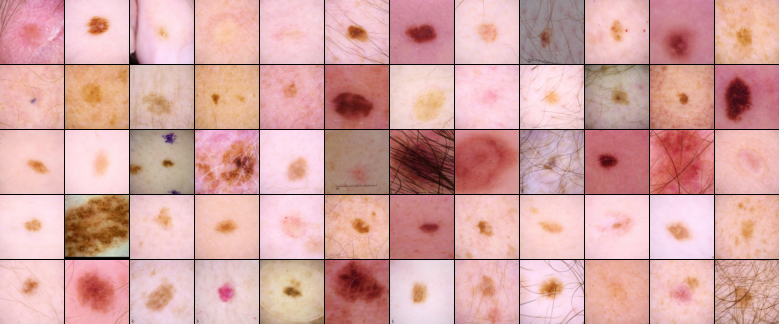

In [35]:
# Mostramos imagenes de Train
print('Muestras de Train:')
ds = get_dataset(files_train, CFG).unbatch().take(12*5)   
show_dataset(64, 12, 5, ds)

Muestras de Train con aumento de datos:


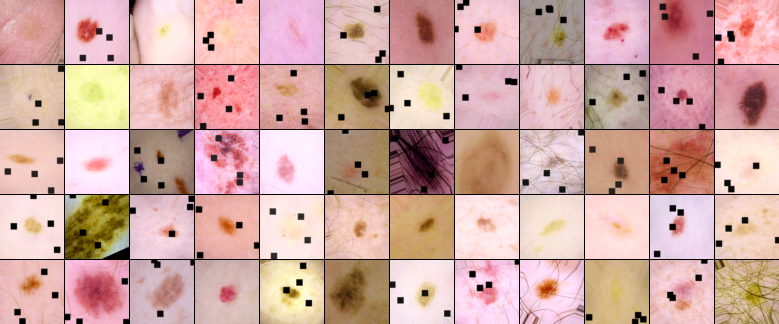

In [41]:
# Mostramos imagenes de Train con Data Augmentation
print('Muestras de Train con aumento de datos:')
ds = get_dataset(files_train, CFG, augment=True).unbatch().take(12*5)   
show_dataset(64, 12, 5, ds)

Aumento de imagen sobre una única imagen:


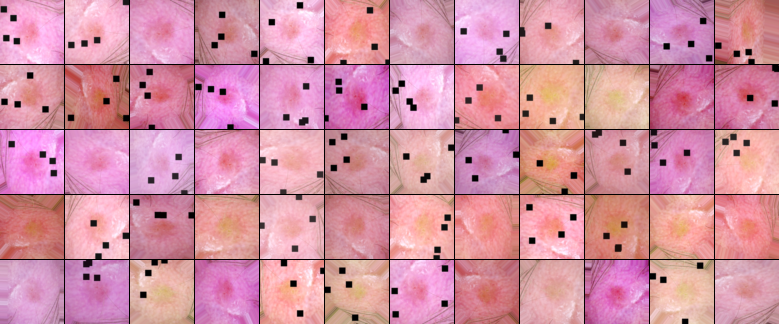

In [42]:
# Image Augmentation para una sola imagen
print('Aumento de imagen sobre una única imagen:')
dataset = tf.data.TFRecordDataset(files_train, num_parallel_reads=AUTO)
dataset = dataset.take(1).cache().repeat()
dataset = dataset.map(lambda example: read_labeled_tfrecord(example), num_parallel_calls=AUTO)    
dataset = dataset.map(lambda img, imgname_or_label: (decode_image(img, cfg=CFG, augment=True), imgname_or_label), num_parallel_calls=AUTO)
dataset = dataset.take(12*5)
dataset = dataset.prefetch(AUTO)
show_dataset(64, 12, 5, dataset)

In [ ]:
# Mostramos imagenes de Test
print('Muestras de Test:')
ds = get_dataset(files_test, CFG, labeled=False).unbatch().take(12*5)   
show_dataset(64, 12, 5, ds)

# Entrenamiento del modelo sin Cross Validation

In [ ]:
# Lectura de datos para entrenamiento sin CV
if CFG['FOLDS']==1:
    
    # Examinamos total de datos de entrenamiento
    files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')))
    print('Total de %i ficheros de train'%len(files_train))

    # Identificamos fold para entrenamiento y para validacion
    idxT = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
    idxV =  np.array([12,13,14])

    # Creamos subconjuntos de Train y Validacion a partir de datos de entrenamiento
    files_train = tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec'%x for x in idxT])
    if CFG['INC2019']:
        files_train += tf.io.gfile.glob([GCS_PATH_PREV + '/train%.2i*.tfrec'%x for x in idxT*2+1])
        print('#### Usamos datos de ISIC 2019')
    if CFG['INC2018']:
        files_train += tf.io.gfile.glob([GCS_PATH_PREV + '/train%.2i*.tfrec'%x for x in idxT*2])
        print('#### Usamos datos de ISIC 2018+2017')
    if CFG['M1']:
        files_train += tf.io.gfile.glob([GCS_PATH_MALIG + '/train%.2i*.tfrec'%x for x in idxT])
        print('#### Upsample de muestras MALIGN-1 (ISIC2020)')
    if CFG['M2']:
        files_train += tf.io.gfile.glob([GCS_PATH_MALIG + '/train%.2i*.tfrec'%x for x in idxT+15])
        print('#### Upsample de muestras MALIGN-2 (ISIC Archive web)')
    if CFG['M3']:
        files_train += tf.io.gfile.glob([GCS_PATH_MALIG + '/train%.2i*.tfrec'%x for x in idxT*2+1+30])
        print('#### Upsample de muestras MALIGN-3 (ISIC2019)')
    if CFG['M4']:
        files_train += tf.io.gfile.glob([GCS_PATH_MALIG + '/train%.2i*.tfrec'%x for x in idxT*2+30])
        print('#### Upsample de muestras MALIGN-4 (ISIC2017-18)')
    # np.random.shuffle(files_train); print('#'*25)
    files_valid = tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec'%x for x in idxV])
    files_test = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))

    print('%i ficheros usados para partición de train'%len(files_train))
    print('%i ficheros usados para partición de valid'%len(files_valid))

In [ ]:
# Proceso para caso sin CV
if CFG['FOLDS']==1:

    # Mostramos informacion de FOLD           
    print('#'*85);
    print('#### Tamaño Imagen %i con EfficientNet B%i y Batch Size %i'%
            (CFG['IMG_SIZE'],CFG['EFF_NET'],CFG['BATCH_SIZE']))
    print('#'*85);
    
    # Creamos subconjuntos de Train y Validación a partir de datos de entrenamiento
    np.random.shuffle(files_train);
    
    # Construimos modelo
    K.clear_session()
    with strategy.scope():
        model = build_model(CFG)

    # Definimos callback para guardar el mejor modelo de cada iteración
    sv = tf.keras.callbacks.ModelCheckpoint(MODEL_NAME + '.h5', monitor='val_loss', verbose=CFG['VERBOSE'], save_best_only=True,
                                            save_weights_only=True, mode='min', save_freq='epoch')

    # Iniciamos entrenamiento
    print('\n Inicio entrenamiento modelo ' + MODEL_NAME)
    ds_train = get_dataset(files_train, CFG, augment=True, shuffle=True, repeat=True)
    ds_valid = get_dataset(files_valid, CFG)
    steps_train = count_data_items(files_train) / (CFG['BATCH_SIZE'])

    history = model.fit(ds_train, epochs = CFG['EPOCHS'], callbacks = [sv,get_lr_callback(CFG)], 
                        steps_per_epoch = steps_train, validation_data=ds_valid, verbose=CFG['VERBOSE'])
    print('\n Fin entrenamiento modelo ' + MODEL_NAME)   

    # Mostramos resultados obtenidos
    print('val_loss'); print(history.history['val_loss']);
    print('val_auc'); print(history.history['val_auc']);
    print('loss'); print(history.history['loss']);
    print('auc'); print(history.history['val_auc']);

    # Cargamos el mejor modelo
    print('\n Cargando mejor modelo')
    model.load_weights(MODEL_NAME + '.h5')
    
    # Plot del resultado del entrenamiento
    if CFG['DISPLAY_PLOT']:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(CFG['EPOCHS']),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
        plt.plot(np.arange(CFG['EPOCHS']),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
        x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
        xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
        plt.ylabel('AUC',size=14); plt.xlabel('Epoch',size=14)
        plt.legend(loc=2)

        plt2 = plt.gca().twinx()
        plt2.plot(np.arange(CFG['EPOCHS']),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
        plt2.plot(np.arange(CFG['EPOCHS']),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
        x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
        plt.ylabel('Loss',size=14)
        plt.title('Tamaño Imagen %i, EfficientNet B%i'%(CFG['IMG_SIZE'],CFG['EFF_NET']),size=18)
        plt.legend(loc=3)
        plt.show() 


# Predicciones del modelo sin CV

In [ ]:
# Proceso para caso sin CV
if CFG['FOLDS']==1:
    
    print('\n Predicción de Test sin TTA')
    
    # Recuperamos dataset de test y número de imágenes
    ds_test = get_dataset(files_test, CFG, labeled=False)
    ct_test = count_data_items(files_test)

    # Leemos imagenes y IDs de dataset de test
    ds_test_imgs = ds_test.map(lambda image, image_name: image)
    ds_test_ids = ds_test.map(lambda image, image_name: image_name).unbatch()
    test_ids = next(iter(ds_test_ids.batch(ct_test))).numpy().astype('U')

    # Hacemos predicción
    pred = model.predict(ds_test_imgs)
    pred = pred.reshape(-1)

    # Construimos fichero de predicciones
    print('\n Generamos fichero submission.csv')
    submission = pd.DataFrame(dict(image_name = test_ids, target = pred))
    submission = submission.sort_values('image_name') 
    submission.to_csv('submission_'+MODEL_NAME+'.csv', index=False)


In [ ]:
if CFG['FOLDS']==1:
    
    print('\n Predicción de Test con TTA')
    
    # Generamos dataset con Image Augmentation
    ds_test_aug = get_dataset(files_test, CFG, repeat=True, shuffle=False, labeled=False, augment=True, return_image_names=False)
    
    # Calculamos los steps necesarios para model.predict()
    ct_test = count_data_items(files_test)
    STEPS = ct_test/CFG['BATCH_SIZE'] * CFG['TTA']

    # Se hace predicción sobre el dataset de test aumentado
    preds_TTA = model.predict(ds_test_aug,steps=STEPS,verbose=CFG['VERBOSE'])[:CFG['TTA']*ct_test,]                                                          
    # Agrupamos y hacemos promedio sobre las n imagenes aumentadas
    preds_TTA = np.stack(np.split(preds_TTA, CFG['TTA']),axis=1)
    preds_TTA = np.mean(preds_TTA, axis=1)
    preds_TTA = preds_TTA.reshape(-1)

    # Construimos fichero de predicciones
    print('\n Generamos fichero submission.csv con TTA')
    submission_TTA = pd.DataFrame(dict(image_name = test_ids, target = preds_TTA))
    submission_TTA = submission_TTA.sort_values('image_name')
    submission_TTA.to_csv('submission_TTA_'+MODEL_NAME+'.csv', index=False)


# Entrenamiento con Cross Validation

In [ ]:
# TRAIN CON CROSS VALIDATION

if CFG['FOLDS']>1 :
    
    # Definimos pesos para ponderar cada fold
    WGTS = [1/CFG['FOLDS']] * CFG['FOLDS']
    print('WGTS = ' + str(WGTS))

    # Preparamos proceso KFold y inicializamos variables:
    # oof_pred: Array para predicciones out-of-fold  con TTA
    # oof_tar: Array para target de datos out-of-fold
    # oof_names: Array para nombres de fichero de datos out-of-fold
    # oof_val: Array de score AUC de entrenamiento out-of-fold
    # oof_fold: Array identificador del número de fold
    # preds: Array con promedio TTA de Test para todos los folds calculados
    
    skf = KFold(n_splits=CFG['FOLDS'],shuffle=True,random_state=CFG['SEED'])
    oof_pred = []; oof_tar = []; oof_val = []; oof_names = []; oof_folds = [] 
    preds = np.zeros((count_data_items(files_test),1))

    # Iniciamos iteracion de Folds
    for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
        
        # Inicializamos contexto TPU
        if DEVICE=='TPU':
            if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
        
        # Mostramos informacion de FOLD            
        print('#'*85);
        print('#### FOLD',fold+1)
        print('#### Tamaño Imagen %i con EfficientNet B%i y Batch Size %i'%
                (CFG['IMG_SIZE'],CFG['EFF_NET'],CFG['BATCH_SIZE']))
        print('#'*85);

        # Creamos subconjuntos de Train y Validación a partir de datos de entrenamiento
        files_train = tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec'%x for x in idxT])
        if CFG['INC2019']:
            files_train += tf.io.gfile.glob([GCS_PATH_PREV + '/train%.2i*.tfrec'%x for x in idxT*2+1])
            print('#### Usamos datos de ISIC 2019')
        if CFG['INC2018']:
            files_train += tf.io.gfile.glob([GCS_PATH_PREV + '/train%.2i*.tfrec'%x for x in idxT*2])
            print('#### Usamos datos de ISIC 2018+2017')
        if CFG['M1']:
            files_train += tf.io.gfile.glob([GCS_PATH_MALIG + '/train%.2i*.tfrec'%x for x in idxT])
            print('#### Upsample de muestras MALIGN-1 (ISIC2020)')
        if CFG['M2']:
            files_train += tf.io.gfile.glob([GCS_PATH_MALIG + '/train%.2i*.tfrec'%x for x in idxT+15])
            print('#### Upsample de muestras MALIGN-2 (ISIC Archive web)')
        if CFG['M3']:
            files_train += tf.io.gfile.glob([GCS_PATH_MALIG + '/train%.2i*.tfrec'%x for x in idxT*2+1+30])
            print('#### Upsample de muestras MALIGN-3 (ISIC2019)')
        if CFG['M4']:
            files_train += tf.io.gfile.glob([GCS_PATH_MALIG + '/train%.2i*.tfrec'%x for x in idxT*2+30])
            print('#### Upsample de muestras MALIGN-4 (ISIC2017-18)')
        np.random.shuffle(files_train)
        files_valid = tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec'%x for x in idxV])
        files_test = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))

        # Construimos modelo
        K.clear_session()
        with strategy.scope():
            model = build_model(CFG)

        # Definimos callback para guardar el mejor modelo de cada iteración
        sv = tf.keras.callbacks.ModelCheckpoint(
            'ModelFold-%i.h5'%fold, monitor='val_loss', verbose=CFG['VERBOSE'], save_best_only=True,
            save_weights_only=True, mode='min', save_freq='epoch')  

        # Iniciamos entrenamiento
        print("\n Inicio entrenamiento modelo")
        ds_train = get_dataset(files_train, CFG, augment=True, shuffle=True, repeat=True)
        ds_valid = get_dataset(files_valid, CFG)
        steps_train = count_data_items(files_train) // (CFG['BATCH_SIZE'])

        history = model.fit(ds_train, epochs = CFG['EPOCHS'], callbacks = [sv,get_lr_callback(CFG)],
                            steps_per_epoch = steps_train, validation_data=ds_valid, verbose=CFG['VERBOSE'])
        print("\n Fin entrenamiento modelo \n")   

        # Mostramos resultados obtenidos
        print('val_loss'); print(history.history['val_loss']);
        print('val_auc'); print(history.history['val_auc']);
        print('loss'); print(history.history['loss']);
        print('auc'); print(history.history['val_auc']);

        # Cargamos el mejor modelo
        print('\n Cargando mejor modelo')
        model.load_weights('ModelFold-%i.h5'%fold)

        # Predicción OOF con TTA
        print('\n Predicción de OOF con TTA')
        ds_valid = get_dataset(files_valid, CFG, repeat=True, labeled=False, augment=True, return_image_names=False)
        ct_valid = count_data_items(files_valid)
        steps_valid = CFG['TTA'] * ct_valid / CFG['BATCH_SIZE']
        pred = model.predict(ds_valid, steps=steps_valid, verbose=CFG['VERBOSE'])[:CFG['TTA']*ct_valid,] 
        oof_pred.append(np.mean(pred.reshape((ct_valid,CFG['TTA']),order='F'),axis=1) )                 

        # Recuperamos las targets y nombres para OOF
        ds_valid_target = get_dataset(files_valid, CFG, augment=False)
        oof_tar.append(np.array([target.numpy() for img, target in iter(ds_valid_target.unbatch())]) )
        ds_valid_names = get_dataset(files_valid, CFG, labeled=False, augment=False)
        oof_names.append(np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds_valid_names.unbatch())]))
        oof_folds.append(np.ones_like(oof_tar[-1],dtype='int8')*fold)    

        # Mostramos resultados OOF obtenidos
        auc = roc_auc_score(oof_tar[-1],oof_pred[-1])
        oof_val.append(np.max( history.history['val_auc'] ))
        print('####### FOLD %i OOF AUC sin TTA = %.3f, con TTA = %.3f'%(fold+1,oof_val[-1],auc))
        
        # Finalmente hacemos prediccion de Test con TTA
        print('\n Predicción de Test con TTA')
        ds_test = get_dataset(files_test, CFG, repeat=True, labeled=False, augment=True, return_image_names=False)
        ct_test = count_data_items(files_test)
        steps_test = ct_test / CFG['BATCH_SIZE'] * CFG['TTA']
        pred = model.predict(ds_test, steps=steps_test, verbose=CFG['VERBOSE'])[:CFG['TTA']*ct_test,]
        preds[:,0] += np.mean(pred.reshape((ct_test,CFG['TTA']),order='F'),axis=1) * WGTS[fold]

        # Se presenta el plot del resultado obtenido
        if CFG['DISPLAY_PLOT']:
            plt.figure(figsize=(15,5))
            plt.plot(np.arange(CFG['EPOCHS']),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
            plt.plot(np.arange(CFG['EPOCHS']),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
            x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
            xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
            plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
            plt.ylabel('AUC',size=14); plt.xlabel('Epoch',size=14)
            plt.legend(loc=2)
            plt2 = plt.gca().twinx()
            plt2.plot(np.arange(CFG['EPOCHS']),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
            plt2.plot(np.arange(CFG['EPOCHS']),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
            x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
            ydist = plt.ylim()[1] - plt.ylim()[0]
            plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
            plt.ylabel('Loss',size=14)
            plt.title('FOLD %i - Tamaño Imagen %i, EfficientNet B%i'%(fold+1,CFG['IMG_SIZE'],CFG['EFF_NET']),size=18)
            plt.legend(loc=3)
            plt.show()

In [ ]:
if CFG['FOLDS']>1 :
    # Cálculo global de OOF AUC
    oof_pred = np.concatenate(oof_pred)
    oof_tar = np.concatenate(oof_tar)
    oof_names = np.concatenate(oof_names)
    oof_folds = np.concatenate(oof_folds)

    auc = roc_auc_score(oof_tar,oof_pred)
    print('Total AUC OOF con TTA = %.3f'%auc)

    # Guardar OOF
    print('\n Generamos fichero oof.csv')
    df_oof = pd.DataFrame(dict(
        image_name = oof_names, target=oof_tar, pred = oof_pred, fold=oof_folds))
    df_oof.to_csv('oof.csv',index=False)
    df_oof.head()

# Predicciones del modelo con CV

In [ ]:
if CFG['FOLDS']>1 :
    # Recuperamos nombres de imagen
    ds_test = get_dataset(files_test, CFG, labeled=False)
    image_names = np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds_test.unbatch())])
    
    # Construimos fichero CSV final
    print('\n Generamos fichero submission_CV.csv')
    submission = pd.DataFrame(dict(image_name=image_names, target=preds[:,0]))
    submission = submission.sort_values('image_name') 
    submission.to_csv('submission_CV.csv', index=False)
    submission.head()
    plt.hist(submission.target,bins=100)
    plt.show()

In [ ]:
# Acknowledgements & Inspiration:
# https://www.kaggle.com/vbhargav875/efficientnet-b5-b6-b7-tf-keras
# https://www.kaggle.com/agentauers/incredible-tpus-finetune-effnetb0-b6-at-once
# https://www.kaggle.com/nroman/melanoma-pytorch-starter-efficientnet?scriptVersionId=40165150
# https://www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords